# Access to data in the cloud (GCS)

## Import modules and libraries

*First, let's make sure the Python env is correct to run this notebook*:

In [ ]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2023/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"),
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()

/tmp/tmpnzjzwzyp/utils.py:39: UserWarning: 
Running on Google Colab, this set-up can take a few minutes
Be aware that your changes won't be saved unless you save this Notebooks on your G-Drive
  warnings.warn(


*Then, import the usual suspects*:

In [ ]:
import xarray as xr
from intake import open_catalog

## Use intake catalog of data

The catalog also uses the gcsfs entry point, but with intake it's transparent to the user:

### Access and listing of the catalog

In [ ]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2023/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_sdl_homogeneous',
 'argo_global_vertical_mean',
 'en4',
 'sea_surface_height']

### Connect to data

In [ ]:
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173,
                                      lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

# Ocean Heat Content (OHC)

## Intro

In [ ]:
import numpy as np

Firstly, we consider the density $\rho$ and heat capcity $C_p$ as constant.
* $\rho$ = 1035 $kg/m^{3}$
* $C_{\rho}$ =  4,186 J/(kg ⋅ K)

In [ ]:
rho = 1035 # kg/m3
Cp = 4186 # J/K/kg

Then wee can get the $OHC(x, y, z, t) [J]$ with
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot V(x,y,z) \cdot T(x,y,z,t)$$
because the temperature $T$ can be obtained directly in the database, the main problem is to calculate the volume $V$ for the given latitude, longitude and depth.

## Calculation for V

We divide the ocean into cubes, each cube can be indicated by the longitude, latitude and deapth. The volume of cubes can be calculated with:
$$dV(x,y,z) = dA(x,y) \cdot dH(z)$$
$dA(x,y)$ presents the sub-area for cubes indicated by the given latitude and longitude. $dH(z)$ is the height of cubes, it may change according to the depth.

By considering the earth as a regular ball, we can get $dA(x,y)$ with:
$$dA(x,y) = R^2 ⋅ dϕ ⋅ dλ ⋅ cos(lat[rad])$$
R is the radius of the earth, $dϕ$ and $dλ$ can be obtained by `np.deg2rad(1.)`, $lat[rad]$ means the latitude in rad.

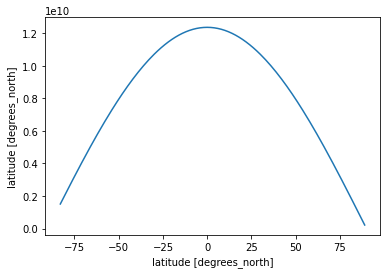

In [ ]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))
dA.plot()

We add the result of $dA(x,y)$ into the dataset.

In [ ]:
ds['dA'] = xr.DataArray(dA, dims=("lat"))

Then we need to calculate the height with given depth. By considering the given depth as the center of cubes, we can divide the cubes in the middle of 2 given depths. For the first and the last cube, we start from the surface of the ocean and end at the last depth we have.

In [ ]:
depths = ds['depth']
depths = np.array((depths))
dz_0 = np.array(depths[0] + (depths[1]-depths[0])/2)
dz_i = (depths[1:-1]-depths[:-2])/2+(depths[2:]-depths[1:-1])/2
dz_N = np.array((depths[-1]-depths[-2])/2)

dz_0 = dz_0.reshape((1,1))
dz_N = dz_N.reshape((1,1))
dz_i = dz_i.reshape((-1,1))

dz = np.concatenate((dz_0, dz_i, dz_N))
dz = dz.reshape((-1))

We add the result of $dH(z)$ into the dataset.

In [ ]:
ds['dz'] = xr.DataArray(dz, dims=("depth"))

## Calculation for OHC

Then wee can get the $OHC(x, y, z, t) [J]$ with
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot A(x,y) \cdot H(z) \cdot T(x,y,z,t)$$

In [ ]:
ds['OHC'] = rho * Cp * ds['temperature'] * ds['dz'] * ds['dA'] 

And then, we are going to see the result in 2 situations:
1. Depth < 2000
2. Depth < 700

In [ ]:
depth2000 = ds.sel(depth=slice(None,2000))
depth700 = ds.sel(depth=slice(None,700))

For each situation, we calculate the OHC for the whole ocean.

In [ ]:
depth2000['S_z_OHC'] = depth2000['OHC'].sum('depth')
depth2000['sum_S_z_OHC'] = depth2000['S_z_OHC'].sum(('lon','lat'))
depth2000['OHC_par_z'] = depth2000['OHC']/ds['dz']

In [ ]:
depth700['S_z_OHC'] = depth700['OHC'].sum('depth')
depth700['sum_S_z_OHC'] = depth700['S_z_OHC'].sum(('lon','lat'))
depth700['OHC_par_z'] = depth700['OHC']/ds['dz']

## Result present

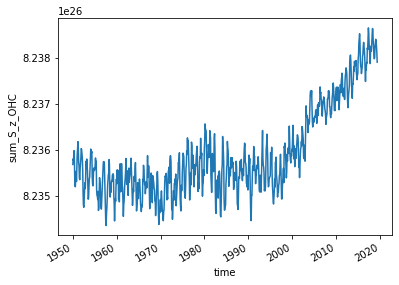

In [ ]:
depth2000['sum_S_z_OHC'].plot()

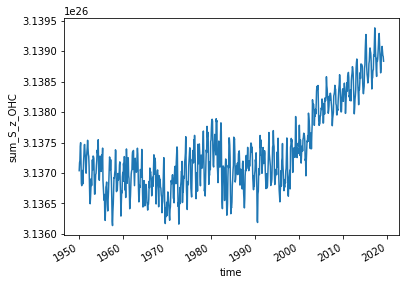

In [ ]:
depth700['sum_S_z_OHC'].plot()

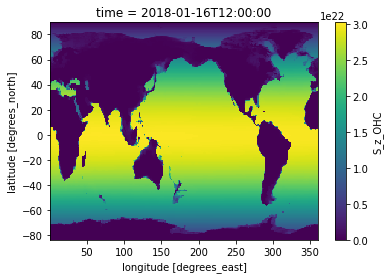

In [ ]:
depth2000['S_z_OHC'].sel(time='2018', method='nearest').plot()

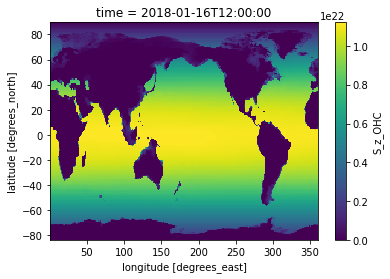

In [ ]:
depth700['S_z_OHC'].sel(time='2018', method='nearest').plot()

# Regression

## Prepare the data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def regressor_predict(regressor, X_train, y_train, X_pred, X_plt_train, X_plt_pred, title="Predict"):
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_pred)
  
  plt.figure(figsize=(15,5))
  plt.title(title)
  plt.plot(X_plt_train,y_train,c='r')
  plt.plot(X_plt_pred,y_pred,c='b')

In [ ]:
X_aff = depth700.time
X_2019 = np.arange(0,len(depth700.time),1).reshape((-1,1))
X_2100 = np.arange(0,1801,1).reshape((-1,1)) # car janvier 2100 est le 1801ème mois (si jan 1950 est le premier)

Y_700 = np.array(depth700.sum_S_z_OHC).reshape((-1,1))
Y_2000 = np.array(depth2000.sum_S_z_OHC).reshape((-1,1))

In [ ]:
# X composed with sin and cos
col1 = X_2019
col2 = np.sin(2*np.pi*(1/12)*col1)
col3 = np.sin(2*np.pi*(1/12)*col1)
X_sc_2019 = np.hstack((col1,col2,col3))

col1 = X_2100
col2 = np.sin(2*np.pi*(1/12)*col1)
col3 = np.sin(2*np.pi*(1/12)*col1)
X_sc_2100 = np.hstack((col1,col2,col3))

## Simple Linear Regression

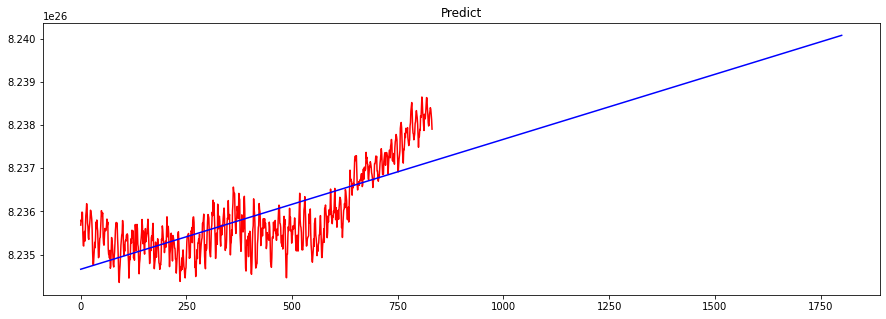

In [ ]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
regressor_predict(lr1, X_2019, Y_2000, X_2100, X_2019, X_2100)

## Multiple Linear Regression

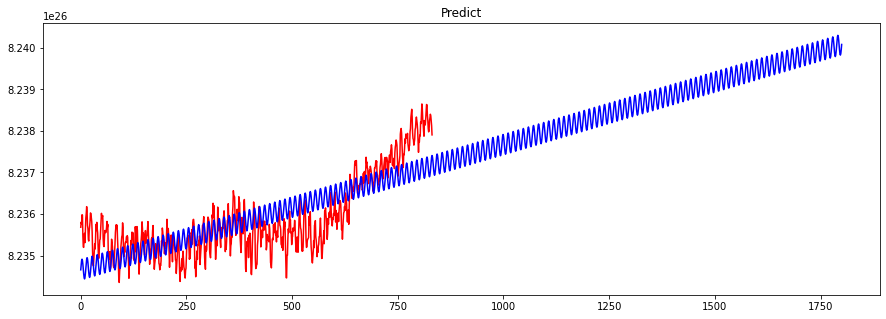

In [ ]:
lr2 = LinearRegression()
regressor_predict(lr2, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100)

## Decision Tree Regressor - with X_sc

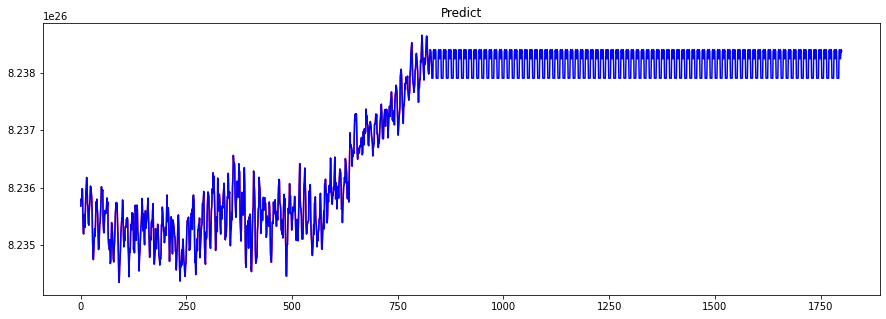

In [ ]:
from sklearn.tree import DecisionTreeRegressor
rf1 = DecisionTreeRegressor()
regressor_predict(rf1, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100)

## Decision Tree Regressor - with X

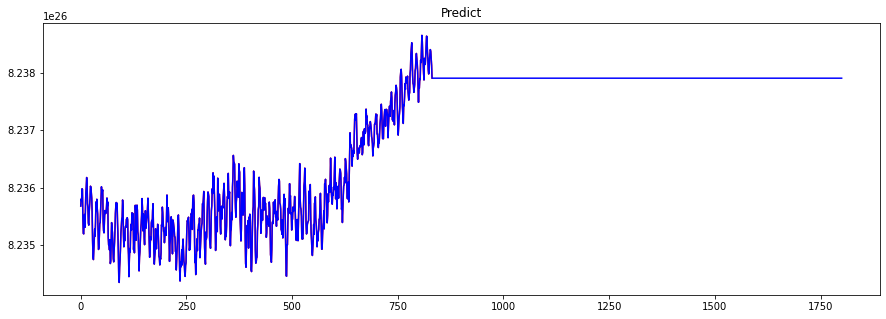

In [ ]:
rf2 = DecisionTreeRegressor()
regressor_predict(rf2, X_2019, Y_2000, X_2100, X_2019, X_2100)

## Ada Boost Regressor

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


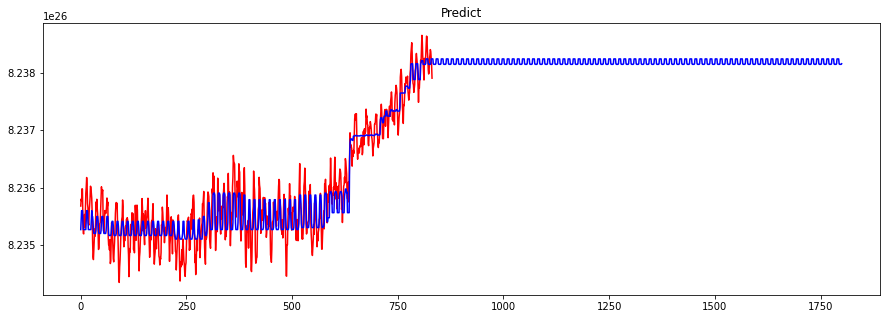

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
regressor_predict(ada, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100)

In [ ]:
from sklearn.svm import SVR
t = np.arange(0,len(depth700.time),1)
model=SVR(C=50^30, epsilon=10^30)
model.fit(t[:,None],depth2000.sum_S_z_OHC)
y_hat=model.predict(t[:,None])

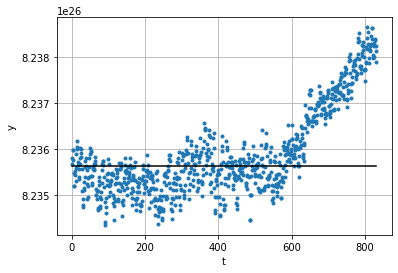

In [ ]:
plt.plot(t,depth2000.sum_S_z_OHC,'.')
plt.plot(t,y_hat,'k-')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()